In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kipet import KipetModel

    Set objects from pyomo.core.base.set or pyomo.core.  (deprecated in 5.7)
    (called from <frozen importlib._bootstrap>:219)
_SetProduct not found


### Parameter Estimation for a fed batch reaction
$A + B \rightarrow C$

Initial conditions in reactor: 
* Initial volume $V_0=1L$
* $c_{A0} = 2, c_{B0} = 0, c_{C0} = 0$ (mol/L).

A stream of $B$ with concentration $2 mol/L$ is charged into reactor at rate $0.1 L/min$ over 15min.

Data is simulated using reaction rate constant $k_1=0.1 min^{-1}$ with added noise

Governing equations are:
$$
\begin{eqnarray}
\frac{dc_A}{dt} &=& -\frac{c_Aqin_B}{V} - k_1c_Ac_B \\
\frac{dc_B}{dt} &=& \frac{(cin_B - c_B)qin_B}{V} - k_1c_Ac_B \\
\frac{dc_C}{dt} &=& -\frac{c_Cqin_B}{V} + k_1c_Ac_B \\
\frac{dV}{dt} &=& qin_B
\end{eqnarray}
$$

In [2]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('fed_batch_parest')

r1.add_parameter('k1', init = 0.1)

r1.add_component('A', state = 'concentration', init = 2.0)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)

r1.add_component('V', state = 'state', init = 1.0)

r1.add_component('qin_B', state = 'trajectory')
r1.add_algebraic_variables(['qin_B'])

cin_B = 2

In [3]:
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.Z[t,'A'] * m.Y[t,'qin_B']/m.X[t,'V']-m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['B'] = (cin_B*m.Y[t,'qin_B'] - m.Z[t,'B'] * m.Y[t,'qin_B'])/m.X[t,'V']- m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['C'] = -m.Z[t,'C'] * m.Y[t,'qin_B']/m.X[t,'V'] + m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
    exprs['V'] = m.Y[t, 'qin_B']
    return exprs

r1.add_equations(rule_odes)

In [4]:
qin_B_df = pd.DataFrame({'t':[0, 15, 16], 'qin_B': [0.1, 0.1, 0]}).set_index('t')
qin_B_df

,qin_B
t,
0,0.1
15,0.1
16,0.0


In [5]:
r1.add_dataset('Traj', category = 'trajectory', data = qin_B_df)
r1.datasets['Traj'].data

,qin_B
t,
0,0.1
15,0.1
16,0.0


In [6]:
#r1.fix_from_trajectory('Y', 'qin_B', 'Traj')

In [7]:
filename = '/home/paperspace/learn_kipet/my_data_sets/ABC_fedbatch.csv'
C_data = pd.read_csv(filename, index_col = 0)
C_data = C_data[['A', 'B', 'C']]
r1.add_dataset('C_data', category='concentration', data = C_data)
r1.datasets['C_data'].data

,A,B,C
0.000000,2.083423,0.000000,0.000000
0.006957,2.050325,0.001389,0.000001
0.125632,1.819311,0.024509,0.000306
0.556208,2.044662,0.099940,0.005443
1.495467,1.541831,0.228099,0.032088
3.140156,1.213143,0.376072,0.101885
5.778965,1.342635,0.514788,0.217732
10.109477,0.844124,0.649458,0.355846
15.010179,0.700708,0.753979,0.439982
16.201092,-0.063078,0.723019,0.470846


In [8]:
#r1.settings.collocation.nfe = 60

In [9]:
r1.fix_from_trajectory('Y', 'qin_B', 'Traj')
r1.set_times(0, 60.0)

In [10]:
r1.settings.solver.linear_solver = 'ma27'
r1.run_opt()  

Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
0 60.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.p


RESULTS
Z:
                   A         B             C
0.000000   2.000000  0.000000  0.000000e+00
0.001079   1.999784  0.000216  2.248753e-08
0.004487   1.999103  0.000897  3.887769e-07
0.006957   1.998609  0.001389  9.341183e-07
0.025358   1.994929  0.005046  1.236097e-05
...             ...       ...           ...
58.519048  0.034680  0.466361  7.494795e-01
58.907088  0.034079  0.465760  7.500804e-01
59.076545  0.033820  0.465502  7.503393e-01
59.611960  0.033016  0.464697  7.511436e-01
60.000000  0.032445  0.464127  7.517137e-01

[151 rows x 3 columns]

Cm:
                   A         B         C
0.000000   2.083423  0.000000  0.000000
0.006957   2.050325  0.001389  0.000001
0.125632   1.819311  0.024509  0.000306
0.556208   2.044662  0.099940  0.005443
1.495467   1.541831  0.228099  0.032088
3.140156   1.213143  0.376072  0.101885
5.778965   1.342635  0.514788  0.217732
10.109477  0.844124  0.649458  0.355846
15.010179  0.700708  0.753979  0.439982
16.201092 -0.063078  0.723019

In [11]:
# Display the results
r1.results.show_parameters


The estimated parameters are:
k1 0.09665537045281214


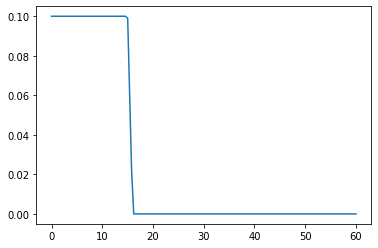

In [12]:
plt.plot(r1.results.Y.index, r1.results.Y['qin_B'])

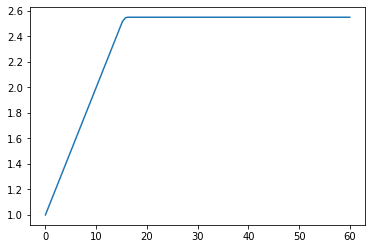

In [13]:
plt.plot(r1.results.X.index, r1.results.X['V'])

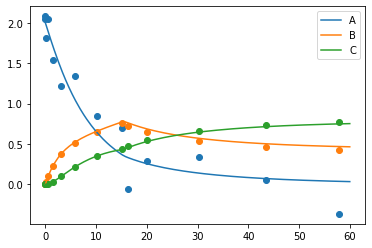

In [14]:
fig, ax = plt.subplots()
for c in ['A', 'B', 'C']:
    ax.plot(r1.results.Z.index, r1.results.Z[c], label = c)
    ax.scatter(r1.datasets['C_data'].data.index, r1.datasets['C_data'].data[c])
ax.legend()